# Creating the Boundary Conditions

This notebook serves as a demo for the creation of model boundary conditions. These boundary conditions are shown for Mike's Calfornia Current regional model. You can follow and/or adapt this notebook based on your configuration if you are using a regional domain.

First, import packages to re-create and visualize the model fields here:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [3]:
# define the input directory
input_dir = os.getcwd()

## Constructing the Boundary Conditions
For my model, I will define a relaxation boundary for Elkhorn Slough. 

### Step 1: Define Model Grid

In [7]:
# define the parameters that will be used in the data file
x_min, x_max = -121.795, -121.739
y_min, y_max =  36.80,    36.861

delX = 0.00015556
delY = 0.00025417
xgOrigin = -121.795
ygOrigin = 36.8
n_rows = 240
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(x_min + delX/2, x_max + delX/2, delX)  # lon centers
yc = np.arange(y_min + delY/2, y_max + delY/2, delY)  # lat centers
XC, YC = np.meshgrid(xc, yc)
delR = np.array([1, 2, 3, 4, 5])  # 5 layers (total 15 m depth)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'slough_bathymetry.bin'),'>f4').reshape(np.shape(XC))

bathy.shape
# If your bathy is negative in the ocean and >=0 on land:
bathy_pd = np.maximum(0.0, -bathy)   # positive-down depth; land becomes 0


In [16]:
def create_hFacC_grid(bathy_pd, delR):
    """
    bathy_pd: 2D array, POSITIVE-DOWN ocean depth (meters). Land = 0.
    delR:     1D array of layer thicknesses (surface to bottom)
    """
    ny, nx = bathy_pd.shape
    nz = len(delR)
    hFacC = np.zeros((nz, ny, nx), dtype=float)

    z_edges = np.concatenate(([0.0], np.cumsum(delR)))   # layer interfaces
    for k in range(nz):
        z_top, z_bot = z_edges[k], z_edges[k+1]
        full    = bathy_pd >= z_bot
        partial = (bathy_pd >  z_top) & (bathy_pd <  z_bot)

        hFacC[k, full]    = 1.0
        hFacC[k, partial] = (bathy_pd[partial] - z_top) / (z_bot - z_top)

    return hFacC

# Recompute with positive-down depths
hFacC = create_hFacC_grid(bathy_pd, delR)

# Surface-water mask (k=0): 1 if the top cell is wet at all
mask_surface = (hFacC[0] > 0).astype(np.int8)

# Or, "any layer is wet" mask (for plotting coastline-ish land/sea)
mask_any = (hFacC.max(axis=0) > 0).astype(np.int8)

C:\Users\rilee\miniconda3\envs\ms274\Lib\site-packages\matplotlib\colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


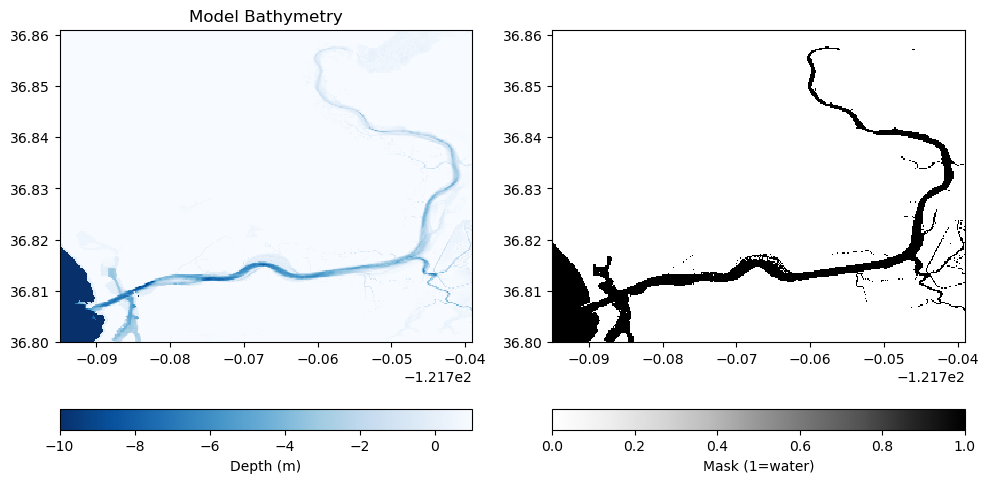

In [17]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-10, vmax=1, cmap='Blues_r')
plt.colorbar(C, orientation='horizontal', label='Depth (m)')
plt.title('Model Bathymetry')


plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask_surface, vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation='horizontal', label='Mask (1=water)')
#plt.title(f'Mask (depth level = {depth_level})')

plt.tight_layout()
plt.show()

In [18]:
# define boundary indices
# Example: only relaxing the west boundary
west_idx = 0       # first column
nbdry = 10         # number of points to taper relaxation into the domain

### Step 2: Create tapering relaxation mask

In [19]:
ny, nx = XC.shape
relax_mask_west = np.zeros((ny, nx))

# Cosine taper into the domain
for i in range(nbdry):
    weight = 0.5 * (1 - np.cos(np.pi * (i+1) / nbdry))
    relax_mask_west[:, west_idx + i] = weight

In [20]:
#compiute relaxation field
init_dir = 'C:/Users/rilee/MS 274/Lectures/Week 8'
nx, ny = 360, 240
nz = 1
tau = 24*3600  # 1-day relaxation timescale in seconds

def read_bin(file_path, shape):
    return np.fromfile(file_path, dtype='>f4').reshape(shape)

theta_init = read_bin(os.path.join(init_dir, 'Temp_IC.bin'), (nz, ny, nx))
salt_init  = read_bin(os.path.join(init_dir, 'Sal_IC.bin'),  (nz, ny, nx))
DO_init    = read_bin(os.path.join(init_dir, 'DO_IC.bin'),    (nz, ny, nx))


In [22]:
# Expand to 3D if needed
theta_init_3d = np.expand_dims(theta_init, axis=0)  # shape (1, ny, nx)
salt_init_3d  = np.expand_dims(salt_init, axis=0)
DO_init_3d    = np.expand_dims(DO_init, axis=0)

# Multiply by relaxation mask (broadcasting in vertical)
theta_relax = theta_init_3d * relax_mask_west
salt_relax  = salt_init_3d  * relax_mask_west
DO_relax    = DO_init_3d    * relax_mask_west


In [24]:
#create output directory
output_dir = os.path.join(input_dir, 'obcs')
os.makedirs(output_dir, exist_ok=True)

In [25]:
#save the relaxation fields as binary
# Save the temperature relaxation field
theta_relax.astype('>f4').tofile(os.path.join(output_dir, 'THETA_west_relax.bin'))

# Save the salinity relaxation field
salt_relax.astype('>f4').tofile(os.path.join(output_dir, 'SALT_west_relax.bin'))

# Save the DO relaxation field
DO_relax.astype('>f4').tofile(os.path.join(output_dir, 'DO_west_relax.bin'))

# Save the mask (optional but recommended)
relax_mask_west.astype('>f4').tofile(os.path.join(output_dir, 'mask_west.bin'))


As we can see, my model boundary (green) is completely surrounded by the points in tile 8 and 11 (black). I also note that there is extraneous information in points with longitude greater than ~140 - I will omit these points as well. Given these observations, now I read in points from just those tiles to use in interpolation:

In [40]:
# make a list to hold all of the ECCO grids
BC_grids = []
timesteps = 12 # data is monthly

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    # create a grid of zeros to fill in
    N = 90*90
    BC_grid = np.zeros((timesteps, np.size(ecco_RF_tiles), N*len(tile_list)))

    for timestep in range(timesteps):
    
        if 'VEL' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,
                                          file_prefix_dict['UVEL']+'_'+
                                          str(year)+'-'+'{:02d}'.format(timestep+1)+
                                         '_ECCO_V4r4_native_llc0090.nc'))
            u_grid = ds.variables['UVEL'][:,:,:,:,:]
            v_grid = ds.variables['VVEL'][:,:,:,:,:]
            ds.close()
        else:
            ds = nc4.Dataset(os.path.join(data_folder,
                                          file_prefix_dict[variable_name]+'_'+
                                          str(year)+'-'+'{:02d}'.format(timestep+1)+
                                         '_ECCO_V4r4_native_llc0090.nc'))
            grid = ds.variables[variable_name][:,:,:,:,:]
            ds.close()
        
        # loop through the tiles
        points_counted = 0
        for tile_number in tile_list:
            if 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
                if variable_name == 'UVEL':
                    if tile_number<6:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 u_grid[0, k, tile_number, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 v_grid[0, k, tile_number, :, :].ravel()
                if variable_name == 'VVEL':
                    if tile_number<6:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 v_grid[0, k, tile_number, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 -1*u_grid[0, k, tile_number, :, :].ravel()
            else:
                for k in range(np.size(ecco_RF_tiles)):
                    BC_grid[timestep, k,points_counted:points_counted+N] = \
                         grid[0, k, tile_number, :, :].ravel()
            points_counted += N

    
    # remove the points with positive longitudes
    BC_grid = BC_grid[:,:,local_indices]

    
    BC_grids.append(BC_grid)

In [42]:
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [43]:
from eccoseas.downscale import horizontal

#### use relaxation boundary instead of open ocean boundary

### Step 6: Plotting the Boundary Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [45]:
meta_dict = {
    'THETA': [0, 25, 'viridis'],  # adjust to your temp range
    'SALT':  [0, 35, 'viridis'],   # adjust to salinity
    'DO':    [-5, 15, 'plasma']     # adjust to DO range
}

Then, I'll create all of the subplots:

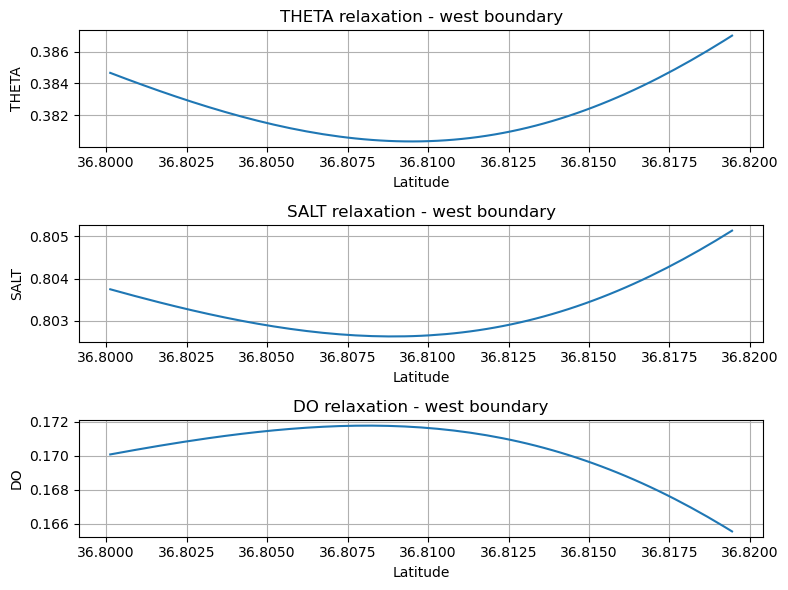

In [31]:
# Example variables
variable_names = ['THETA','SALT','DO']
boundary_list = ['west']

# Set up the figure
fig = plt.figure(figsize=(8,6))
plot_counter = 0

# Vertical coordinate (only 1 layer)
Z = [0]  # surface
delZ = 1  # just for plotting scale


for i, variable_name in enumerate(variable_names):

    # Load the relaxation field (OBCS file)
    file_path = os.path.join(output_dir, f'{variable_name}_west_relax.bin')
    boundary_grid = np.fromfile(file_path, '>f4').reshape((nz, ny, nx))
    
    # For west boundary, extract first column
    x = YC[:, 0]
    y = Z  # vertical; just surface
    data_to_plot = boundary_grid[:, :, 0].squeeze()  # shape (nz, ny)
    
    plot_counter += 1
    plt.subplot(len(variable_names),1,plot_counter)
    
    # Since nz=1, we can just plot horizontal line
    plt.plot(x, data_to_plot.flatten(), label=f'{variable_name} west')
    plt.xlabel('Latitude')
    plt.ylabel(variable_name)
    plt.title(f'{variable_name} relaxation - west boundary')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Step 7: Run-time considerations
To use the grids as boundary conditions in the model, I will use the `obcs` package - short for Open Boundary Condtions. To ensure the boundary conditions are included in the model, I will add a line for `obcs` in my `code/packages.conf` compile time file.

Next, I will add a line with ` useOBCS=.TRUE.` to the `data.pkg` file and a new file called `data.obcs` to my run directory. See Canvas for an editable `data.obcs` file.